# LangGraph Agent with Bedrock AgentCore Memories

This notebook walks through creating a simple LangGraph agent with a chatbot (llm) node and a tool calling node. 

This agent integrates with Amazon Bedrock Agentcore Memory to store messages so that the agent can pick back up where it left off if the conversation is interrupted. 

Before and after each time the LLM node is invoked, the previous `User` message and the generated `LLM` message are saved to Bedrock Agentcore Memory. If the session is interuptted, the agent detects that no messages are present in the state, then lists the past 10 events from the session from Agentcore Memory. These messages are loaded into the state so the agent can have the previous context.

### Pre-requisites for this sample
- Amazon Web Services account
- Amazon Bedrock Agentcore Memory configured - https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory-getting-started.html#memory-getting-started-create-memory
- Amazon Bedrock model access - https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html


In [1]:
from langchain_aws import ChatBedrockConverse

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import SystemMessage

from langchain_aws.memory.bedrock_agentcore import (
    store_agentcore_memory_events,
    list_agentcore_memory_events,
)

from bedrock_agentcore.memory import MemoryClient

config = {"configurable": {"thread_id": "1"}}
memory = InMemorySaver()

llm = ChatBedrockConverse(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    max_tokens=5000,
    region_name="us-west-2"
)

## Configure Agentcore Memory

AgentCore short-term memories are organized by a Memory ID (overall memory store) and then categorized by Actor ID (i.e which user) and Session ID (which chat session). 

Long term memories are stored in namespaces. Please see the long term memory search example notebook for more information. By configuring different strategies (i.e. Summarization, User Preferences) these short term memories are processed async as long term memories in the specified namespace.

In [15]:
REGION = "us-west-2"
MEMORY_ID = "YOUR_MEMORY_ID"
SESSION_ID = "session-10"
ACTOR_ID = "user-1"

# Initialize the memory client
memory_client = MemoryClient(region_name=REGION)

In [3]:
config = {"configurable": {"thread_id": "1"}}
memory = InMemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

## Pre/Post Model Hooks

For this implementation, short term memories (message events) are stored before and after model invocation. Before the model runs, the previous user message is saved. After the model runs, the LLM message is saved. 

If the conversation is just starting or no messages are present in the state, a check is done in Agentcore memory to see if there are any previous events in that actor/session combination. If so, those messages are added as a special System message so that the LLM has the context from the previous interrupted conversation.

In [5]:
def pre_model_hook(state):
    """Store the previous user or tool message before the LLM responds, or load recent history if state is empty"""
    try:
        # Check if there are no messages in the state
        last_message = state["messages"][-1]
        if len(state["messages"]) == 1:
            # Load the last 10 events from memory
            recent_messages = list_agentcore_memory_events(
                memory_client, MEMORY_ID, ACTOR_ID, SESSION_ID, 10
            )
            print("No messages in history, attempting to load from AgentCore memory")
            
            if recent_messages:
                print(f"{len(recent_messages)} recent messages found in AgentCore memory, loading them into context.")

                context_content = "No messages in history, attempting to load from AgentCore memory"
                for i, msg in enumerate(recent_messages, 1):
                    # Extract message details
                    if hasattr(msg, 'content'):
                        content = msg.content
                        role = getattr(msg, 'type', 'unknown')
                    elif isinstance(msg, dict):
                        content = msg.get('content', str(msg))
                        role = msg.get('role', msg.get('type', 'unknown'))
                    else:
                        content = str(msg)
                        role = 'unknown'
                    
                    context_content += f"""
                Message {i}:
                Role: {role.capitalize()}
                Content: {content}
                ---"""
                
                context_content += """
                
                === END HISTORY ===
                
                Please use this context to continue our conversation naturally. You should reference relevant parts of this history when appropriate, but don't explicitly mention that you're loading from memory unless asked.
                """
                # Create a special system message with the previous context
                ai_context_msg = SystemMessage(content=context_content)
                state['messages'] = [ai_context_msg] + [last_message]
                return state
            else:
                print("No past agentcore messages found.")

        # Store the last message (user or tool message) as before
        print(f"Storing event pre-model: {last_message}")
        store_agentcore_memory_events(
            memory_client=memory_client,
            memory_id=MEMORY_ID,
            actor_id=ACTOR_ID,
            session_id=SESSION_ID,
            messages=[last_message]
        )
    except Exception as e:
        print(f"Memory operation failed: {e}")
    
    return state  # Return state unchanged if messages exist or if there was an error



def post_model_hook(state):
    """Store the LLM response after it's generated"""
    try:
        # Get the last message (LLM response)
        if state["messages"]:
            last_message = state["messages"][-1]
            print(f"Storing event post-model: {last_message}")
            store_agentcore_memory_events(
                memory_client=memory_client,
                memory_id=MEMORY_ID,
                actor_id=ACTOR_ID,
                session_id=SESSION_ID,
                messages=[last_message]
            )
    except Exception as e:
        print(f"Memory storage failed: {e}")


def chatbot_with_hooks(state: State):
    # Pre-hook: Store the incoming user/tool message OR load recent history if empty
    modified_state = pre_model_hook(state)
    
    # LLM call
    response = llm_with_tools.invoke(modified_state["messages"])
    
    # Create the new state with all messages including the response
    new_state = {"messages": modified_state["messages"] + [response]}
    
    # Post-hook: Store the LLM response
    post_model_hook(new_state)
    
    return new_state

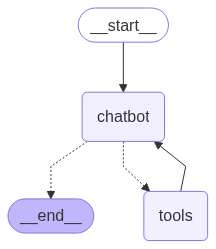

In [6]:
# Bind tools to LLM
llm_with_tools = llm.bind_tools([multiply])

# Build graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_with_hooks)

tool_node = ToolNode(tools=[multiply])
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot", tools_condition, {"tools": "tools", "__end__": "__end__"}
)

graph = graph_builder.compile(checkpointer=memory)
graph

In [7]:
# Helper function to invoke the chatbot
def chat(user_input: str):
    """Send a message to the chatbot and display the response"""
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    
    for event in events:
        # Print the last message (which will be the response)
        event["messages"][-1].pretty_print()

In [8]:
chat("Hello, world!")

================================ Human Message =================================

Hello, world!
No messages in history, attempting to load from AgentCore memory
No past agentcore messages found.
Storing event pre-model: content='Hello, world!' additional_kwargs={} response_metadata={} id='68931e20-11b2-423d-bbef-d4a1a7508ec1'
Storing event post-model: content="Hello! Welcome! How can I assist you today? I have a function available that can multiply two numbers. Would you like me to help you with a multiplication calculation? If so, please provide me with the two numbers you'd like to multiply." additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': '1280187f-a22d-4ec8-97d6-74b84b42437d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 29 Aug 2025 21:39:47 GMT', 'content-type': 'application/json', 'content-length': '531', 'connection': 'keep-alive', 'x-amzn-requestid': '1280187f-a22d-4ec8-97d6-74b84b42437d'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metric

In [9]:
list_agentcore_memory_events(memory_client, MEMORY_ID, ACTOR_ID, SESSION_ID, 10)

[AIMessage(content="Hello! Welcome! How can I assist you today? I have a function available that can multiply two numbers. Would you like me to help you with a multiplication calculation? If so, please provide me with the two numbers you'd like to multiply.", additional_kwargs={'event_id': '0000001756503587000#f06f3cff'}, response_metadata={}),
 HumanMessage(content='Hello, world!', additional_kwargs={'event_id': '0000001756503584000#5a553d5c'}, response_metadata={})]

In [10]:
chat("What's the result of 1337 multiplied by 78?")

================================ Human Message =================================

What's the result of 1337 multiplied by 78?
Storing event pre-model: content="What's the result of 1337 multiplied by 78?" additional_kwargs={} response_metadata={} id='d81510bb-c9a8-474a-9264-0d3e87bbd2fd'
Storing event post-model: content=[{'type': 'text', 'text': "I'll calculate the result of 1337 multiplied by 78 for you."}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 1337, 'b': 78}, 'id': 'tooluse_7ku3y30NS1-Vb-99T2r1Fw'}] additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': 'b813c905-eabd-46f7-901d-7f30daead916', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 29 Aug 2025 21:40:00 GMT', 'content-type': 'application/json', 'content-length': '456', 'connection': 'keep-alive', 'x-amzn-requestid': 'b813c905-eabd-46f7-901d-7f30daead916'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [2296]}, 'model_name': 'us.anthropic.claude-3-7-sonnet-202

## Clearing and loading the previous memories

For this sample, we will clear the in-memory state so that no messages are present. The messages from the conversation will be loaded from Bedrock Agentcore memory so that the agent can continue where the user left off.

In [11]:
def clear_memory(memory, thread_id: str) -> None:
    """ Clear the memory for a given thread_id. """
    try:
        # If it's an InMemorySaver (which MemorySaver is an alias for),
        # we can directly clear the storage and writes
        if hasattr(memory, 'storage') and hasattr(memory, 'writes'):
            # Clear all checkpoints for this thread_id (all namespaces)
            memory.storage.pop(thread_id, None)

            # Clear all writes for this thread_id (for all namespaces)
            keys_to_remove = [key for key in memory.writes.keys() if key[0] == thread_id]
            for key in keys_to_remove:
                memory.writes.pop(key, None)

            print(f"Memory cleared for thread_id: {thread_id}")
            return

    except Exception as e:
        print(f"Error clearing InMemorySaver storage for thread_id {thread_id}: {e}")

In [12]:
# Clear the in-memory messages
thread_id = config.get("configurable").get("thread_id")
print(f"Thread ID: {thread_id}")
memory.delete_thread(config.get("configurable").get("thread_id"))

state = graph.get_state(config)
        
if state and state.values and 'messages' in state.values:
    messages = state.values['messages']
    print(f"📝 Found {len(messages)} messages in conversation state:")
    for i, msg in enumerate(messages):
        print(f"  {i+1}. {msg.type}: {msg.content[:100]}...")
else:
    print("✅ No conversation state found - memory is clear!")

Thread ID: 1
✅ No conversation state found - memory is clear!


In [13]:
chat("What numbers was I multiplying earlier?")

================================ Human Message =================================

What numbers was I multiplying earlier?
No messages in history, attempting to load from AgentCore memory
6 recent messages found in AgentCore memory, loading them into context.
Storing event post-model: content='Based on our earlier conversation, you were asking about multiplying 1337 by 78. I calculated that for you, and the result was 104,286.' additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': 'b2504f9f-0c3b-494d-b478-41cc44bca118', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 29 Aug 2025 21:40:12 GMT', 'content-type': 'application/json', 'content-length': '429', 'connection': 'keep-alive', 'x-amzn-requestid': 'b2504f9f-0c3b-494d-b478-41cc44bca118'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1470]}, 'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'} id='run--8f0bb0ac-588a-479d-aaa9-7392329cb1b6-0' usage_metadata={'input_tokens': 6

In [14]:
state = graph.get_state(config)
state.values["messages"]

[HumanMessage(content='What numbers was I multiplying earlier?', additional_kwargs={}, response_metadata={}, id='012b3c53-725c-4588-a0d4-46489bf80fdf'),
 SystemMessage(content="No messages in history, attempting to load from AgentCore memory\n                Message 1:\n                Role: Ai\n                Content: The result of 1337 multiplied by 78 equals 104,286.\n                ---\n                Message 2:\n                Role: Ai\n                Content: I'll calculate the result of 1337 multiplied by 78 for you.\n                ---\n                Message 3:\n                Role: Tool\n                Content: 104286\n                ---\n                Message 4:\n                Role: Human\n                Content: What's the result of 1337 multiplied by 78?\n                ---\n                Message 5:\n                Role: Ai\n                Content: Hello! Welcome! How can I assist you today? I have a function available that can multiply two numbers. Wou

## Conclusion
As you can see, Bedrock Agentcore memories can be saved and loaded easily using the short term memory API and the helper functions implemented in hooks. 

This is not a one-size fits all approach and developers can utilize the storing/listing/searching memory functionalities in their own node, pre/post model hooks, or as tools themselves. Check out the other examples for various implementations.